# 라이브러리 설치하기

In [ ]:
# !pip install langgraph langsmith langchain_openai tavily-python langchain_community

# 라이브러리 import


In [24]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv

load_dotenv("/home/kevin/projects/langgraph/.env")


True

# 가장 기본적인 챗봇 구현하기

In [54]:
class State(TypedDict):
    """
    메시지는 "list" 타입을 가집니다. `add_messages` 함수는 이 상태 키가 어떻게 업데이트되어야 하는지 정의합니다
    (이 경우, 메시지를 덮어쓰는 대신 리스트에 추가합니다)
    이는 State Dictionary(==Map)가 'messages'라는 키를 가지며, 그 값은 리스트 타입이고 add_messages 함수로 관리된다는 것을 명시적으로 나타냅니다.
    # Annotated에 대한 설명:
    # Annotated는 타입에 추가 메타데이터를 붙이는 데 사용됩니다.
    # 여기서는 'messages'가 리스트 타입이며, add_messages 함수를 통해 관리된다는 것을 나타냅니다.
    # 이는 새 메시지를 추가할 때 기존 리스트를 덮어쓰지 않고 추가한다는 의미입니다.
    # Annotated를 사용함으로써 타입 정보와 함께 추가적인 동작을 명시적으로 정의할 수 있습니다.
    """
    messages: Annotated[list, add_messages]
    
    

graph_builder = StateGraph(State)


## LLM을 어떻게 호출하는지 먼저 확인해보기

In [55]:
state = State()

# 'messages' 키에 값 할당
state['messages'] = [("user", "안녕하세요 내 이름은 상현이야")]

# 'messages' 키의 값 접근
messages = state['messages']

print(messages)

[('user', '안녕하세요 내 이름은 상현이야')]


In [40]:
from langchain_openai import ChatOpenAI
# LLM 모델 설정
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# 챗봇 함수 정의
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [38]:
llm.invoke(state["messages"])

AIMessage(content='안녕하세요, 상현님! 만나서 반갑습니다. 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 16, 'total_tokens': 36, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'stop', 'logprobs': None}, id='run-ddb5da40-f1bf-4159-8ad8-f5cc992ccbb8-0', usage_metadata={'input_tokens': 16, 'output_tokens': 20, 'total_tokens': 36, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

# Graph 구현해보기




![alt text](../../images/chatbot.PNG)

### 노드 추가하기

In [56]:
#graph_builder = StateGraph(State)
graph_builder.add_node("chatbot_node", chatbot)# node명, node에서 사용할 함수

### entry point 추가하기

In [57]:
graph_builder.add_edge(START, "chatbot_node")


In [58]:
graph_builder.add_edge("chatbot_node", END)

## 그래프 컴파일하기

In [60]:
graph = graph_builder.compile()
graph

### 그래프 이미지로 확인하기

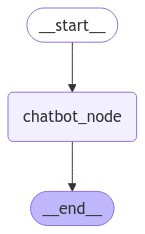

In [63]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

### 챗봇 실행해보기

In [64]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 안녕하세요! 어떻게 도와드릴까요?
Assistant: 죄송하지만, 실시간 날씨 정보를 제공할 수는 없습니다. 하지만, 내일의 날씨를 확인하려면 기상청 웹사이트나 날씨 앱을 이용해 보시는 것을 추천합니다. 도움이 필요하시면 다른 질문 해주세요!
Assistant: Hello! How can I assist you today?
Assistant: 안녕하세요! 무엇을 도와드릴까요?
Goodbye!


# 그래프에 TOOL 추가하기

In [1]:
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_community.tools.google_serper import GoogleSerperResults
from pprint import pprint

In [8]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=3)
tools = [tool]
print(tool.invoke("내일 서울 날씨 어때?"))

[{'url': 'https://www.weather.go.kr/weather/home/main.jsp', 'content': '날씨해설. ※ 10월 11일부터 10월 13일까지의 전망입니다. 오늘 오전까지 전국 대부분 지역에 짙은 안개가 끼는 곳이 많겠습니다. 당분간 내륙을 중심으로 아침 기온이 낮아 쌀쌀하겠고, 낮과 밤의 기온차가 크겠습니다. 오늘 (11일) 오전 (10시)까지 전국 대부분 지역 ...'}, {'url': 'https://weather.com/ko-KR/weather/hourbyhour/l/36994b6d164c4043d2ec43cc7d39f5447d3fc0b10bcc175e4593cd4f929976ea', 'content': '15°. 5%. km/h. 10일 날씨. CAT 4. 10월 9일 23:00. Weather.com 및 The Weather Channel이 제공하는 지역의 시간별 일기예보, 날씨 상태, 강수량, 이슬점, 습도, 바람.'}, {'url': 'https://www.accuweather.com/ko/kr/seoul/226081/weather-today/226081', 'content': "Everything you need to know about today's weather in 서울특별시, 서울시, 대한민국. High/Low, Precipitation Chances, Sunrise/Sunset, and today's Temperature History."}]


In [3]:
tool = GoogleSerperResults(
        k=5,
        gl= "kr",  # 지역을 한국으로 설정
        hl= "ko"   # 언어를 한글로 설정
    )

tools = [tool]

pprint(tool.invoke("내일 서울 날씨 어때?"))

("{'searchParameters': {'q': '내일 서울 날씨 어때?', 'gl': 'us', 'hl': 'en', 'type': "
 "'search', 'num': 10, 'engine': 'google'}, 'answerBox': {'title': 'Naeil, "
 "Mia-dong, Gangbuk-gu, Seoul, South Korea / Weather', 'answer': '56°F', "
 "'source': 'More on weather.com', 'sourceLink': "
 "'https://www.weather.com/wx/today/?lat=37.63&lon=127.03&locale=en_US&par=google'}, "
 "'organic': [{'title': '서울·인천·경기 – 단기예보 - 기상청 날씨누리', 'link': "
 "'https://www.weather.go.kr/w/weather/forecast/short-term.do?stnId=109', "
 "'snippet': '내일. 15일(화) 최저17℃최고25℃. 시각; 날씨; 기온 (체감); 강수량; 강수 확률; 바람; 습도; 한파 "
 "영향. 시각: 01시; 날씨: 흐림; 기온(체감온도) 18℃(18℃); 체감온도: 18℃ ...', 'position': 1}, "
 "{'title': '서울특별시, 서울시, 대한민국 시간별 날씨 - AccuWeather', 'link': "
 "'https://www.accuweather.com/ko/kr/seoul/226081/hourly-weather-forecast/226081', "
 "'snippet': 'RealFeel Shade™67°. 바람북 6mi/h. 대기질나쁨. 최대 자외선 지수1 낮음. 돌풍10mi/h. "
 "습도84%. 이슬점63° F. 구름량100%. 가시거리7mi. 운저30000ft ...', 'position': 2}, {'title': "
 "'서울 실시간 날씨 정보 | 서울 공식 관광정보

In [4]:
from typing import Annotated

from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
# 모델에 TOOL 추가하기
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [4]:
llm.invoke("내일 날씨 검색해줘")

AIMessage(content='죄송하지만, 실시간 날씨 정보를 제공할 수는 없습니다. 하지만, 내일의 날씨를 확인하려면 기상청 웹사이트나 날씨 앱을 이용해 보시는 것을 추천합니다. 도움이 필요하시면 다른 질문 해주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 14, 'total_tokens': 67, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'stop', 'logprobs': None}, id='run-cef68665-1727-450c-b937-b59695fa8556-0', usage_metadata={'input_tokens': 14, 'output_tokens': 53, 'total_tokens': 67, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [5]:
answer = llm_with_tools.invoke("내일 날씨 검색해줘")
pprint(answer)

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_OA7NNjmeFLv31kaetWkXjRyO', 'function': {'arguments': '{"query":"내일 날씨"}', 'name': 'google_serper_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 82, 'total_tokens': 102, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7fcf99bd-9e2e-46d9-9690-1deae18878de-0', tool_calls=[{'name': 'google_serper_results_json', 'args': {'query': '내일 날씨'}, 'id': 'call_OA7NNjmeFLv31kaetWkXjRyO', 'type': 'tool_call'}], usage_metadata={'input_tokens': 82, 'output_tokens': 20, 'total_tokens': 102, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})


In [6]:
"""AIMessage(content='', 
additional_kwargs={'tool_calls': [{'id': 'call_vOY3viMhJlfm8W15tPPgfA8a', 
'function': {'arguments': '{"query":"내일 날씨"}', 'name': 'google_serper_results_json'}, 
'type': 'function'}], 'refusal': None}, 
response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 82, 'total_tokens': 102, 
'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 
'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 
'gpt-4o-mini-2024-07-18', 
'system_fingerprint': 'fp_e2bde53e6e', 
'finish_reason': 'tool_calls', 
'logprobs': None}, 
id='run-816efb48-a751-4d0f-b946-5fee1d64df40-0', 
tool_calls=[{'name': 'google_serper_results_json',
'args': {'query': '내일 날씨'}, 
'id': 'call_vOY3viMhJlfm8W15tPPgfA8a', 
'type': 'tool_call'}], 
usage_metadata={'input_tokens': 82, 'output_tokens': 20, 'total_tokens': 102, 
'input_token_details': {'cache_read': 0}, 
'output_token_details': {'reasoning': 0}})"""


'AIMessage(content=\'\', \nadditional_kwargs={\'tool_calls\': [{\'id\': \'call_vOY3viMhJlfm8W15tPPgfA8a\', \n\'function\': {\'arguments\': \'{"query":"내일 날씨"}\', \'name\': \'google_serper_results_json\'}, \n\'type\': \'function\'}], \'refusal\': None}, \nresponse_metadata={\'token_usage\': {\'completion_tokens\': 20, \'prompt_tokens\': 82, \'total_tokens\': 102, \n\'completion_tokens_details\': {\'audio_tokens\': None, \'reasoning_tokens\': 0}, \n\'prompt_tokens_details\': {\'audio_tokens\': None, \'cached_tokens\': 0}}, \'model_name\': \n\'gpt-4o-mini-2024-07-18\', \n\'system_fingerprint\': \'fp_e2bde53e6e\', \n\'finish_reason\': \'tool_calls\', \n\'logprobs\': None}, \nid=\'run-816efb48-a751-4d0f-b946-5fee1d64df40-0\', \ntool_calls=[{\'name\': \'google_serper_results_json\',\n\'args\': {\'query\': \'내일 날씨\'}, \n\'id\': \'call_vOY3viMhJlfm8W15tPPgfA8a\', \n\'type\': \'tool_call\'}], \nusage_metadata={\'input_tokens\': 82, \'output_tokens\': 20, \'total_tokens\': 102, \n\'input_token_d

### Tool 노드 추가하기

In [5]:
import json
import ast
from langchain_core.messages import ToolMessage
from langchain_core.callbacks.manager import CallbackManagerForToolRun

class BasicToolNode:
    """
    이 노드는 가장 최근의 AI 메시지에서 요청된 도구들을 실행합니다. 
    AI가 특정 도구의 사용을 요청했을 때, 이 노드가 해당 도구들을 실행하는 역할을 담당합니다.
    """

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}  # tool 이름을 키로 하여 tool 객체를 저장

    def serialize_args(self, args):
        """
        JSON 직렬화가 불가능한 객체를 직렬화 가능하도록 변환합니다.
        """
        if isinstance(args, CallbackManagerForToolRun):
            # 필요한 경우 문자열로 변환하거나 객체의 특정 속성을 선택적으로 변환
            return str(args)  # 간단하게 문자열로 변환 (필요에 따라 다르게 구현 가능)
        elif isinstance(args, dict):
            # 재귀적으로 딕셔너리를 순회하며 각 요소를 직렬화
            return {key: self.serialize_args(value) for key, value in args.items()}
        elif isinstance(args, list):
            # 리스트 내의 모든 요소를 직렬화
            return [self.serialize_args(item) for item in args]
        else:
            return args

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        outputs = []
        for tool_call in message.tool_calls:
            # JSON 직렬화 가능하도록 변환
            serialized_args = self.serialize_args(tool_call["args"])
            tool_result = self.tools_by_name[tool_call["name"]].invoke(serialized_args)
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


# tool_node 생성 및 graph_builder에 추가
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)


### 라우팅 함수 추가하기

In [6]:
def route_tools(
    state: State,
):
    """
    conditional_edge에서 사용되며, 마지막 메시지에 TOOL 호출이 있으면 ToolNode로 라우팅합니다.
    그렇지 않으면 END로 라우팅합니다.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"tool_edge의 입력 상태에서 메시지를 찾을 수 없습니다: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# `tools_condition` 함수는 챗봇노드가 도구 사용을 요청하면 "tools"를 반환하고,
# 직접 응답해도 괜찮으면 "END"를 반환함
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # 다음 딕셔너리를 통해 그래프에게 조건의 출력을 특정 노드로 해석하도록 지시함
    # "tools" 외에 다른 이름의 노드를 사용하고 싶다면
    # 딕셔너리의 값을 다른 것으로 업데이트할 수 있음
    # 예: "tools": "my_tools"
    {"tools": "tools", END: END},
)
# 도구가 호출될 때마다 다음 단계를 결정하기 위해 챗봇으로 돌아감
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
#graph_builder.add_edge("chatbot", END) # END를 추가할 필요 없음. route_tools에서 이미 처리하고 있음.
graph = graph_builder.compile()

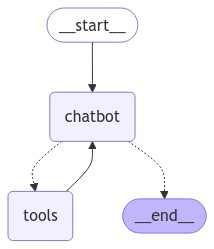

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I assist you today?
Assistant: 안녕하세요! 어떻게 도와드릴까요?
Assistant: 저는 AI 언어 모델로, 특정한 이름은 없습니다. 하지만 여러분이 원하는 이름으로 불러주셔도 좋습니다! 어떻게 도와드릴까요?
Assistant: 저는 AI 언어 모델이라 이름이 없어요. 하지만 여러분이 저를 어떻게 부르든지 괜찮습니다! 도움이 필요하시면 말씀해 주세요.
Assistant: 
Assistant: "{'searchParameters': {'q': '\uc11c\uc6b8 \ub0a0\uc528 \uc608\ubcf4 2023\ub144 10\uc6d4 14\uc77c', 'gl': 'us', 'hl': 'en', 'type': 'search', 'num': 10, 'engine': 'google'}, 'organic': [{'title': '\uc624\ub298\uc758 \ub0a0\uc528 - \uc624\uc804 (2023\ub144 10\uc6d4 14\uc77c) - \uad6d\ubbfc\uc77c\ubcf4', 'link': 'https://www.kmib.co.kr/article/view.asp?arcid=0018762535', 'snippet': '10\uc6d4 14\uc77c \ud1a0\uc694\uc77c, \uc544\uce68 \ub0a0\uc528\uc785\ub2c8\ub2e4.\uc544\uce68 \ucd5c\uc800\uae30\uc628\uc740 \uc11c\uc6b8 14.0\ub3c4, \uc778\ucc9c 13.0\ub3c4, \uc218\uc6d0 12.0\ub3c4, \ucd98\ucc9c 11.0\ub3c4, \uac15\ub989 13.0\ub3c4, \uccad\uc8fc 12.0\ub3c4, \ub300\uc804 11.0\ub3c4, ...', 'date': 'Oct 14, 2023', 'position': 1}, {'title':